# Supervised classification | Loan Lending Club

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import loan_processing as lp
from datetime import datetime as dt
import joblib
import os
import time

# General Remarks

This notebook is intended to perform a supervised classification task on the Lending Club dataset. The goal is to predict whether a loan will be fully paid or charged off. The dataset is composed of 151 columns and 2260668 rows. The target variable is the `loan_status` column, which is a categorical variable with 9 classes.


## Notebook Structure
The notebook is divided into the following sections:

1. Data Exploration
2. Data Cleaning & Feature Engineering
3. Data Preprocessing
4. Model Selection
5. Model Evaluation & Interpretation


## General Settings

Here it's possible to set some general settings for the notebook, tweaking the behavior of the code. This is especially useful to choose whether to run the notebook with the full or only a sampled slice of the dataset using `sampled_mode == True` and `sample_frac` to set the desired fraction. It's also possible to choose the `export_mode` whether results, models and metrics should be exported to .xlsx and .pkl files respectively.

In [3]:
rs = 25 # Setting random seed for reproducibility
export_mode = False # If True, exports all models, metrics and information to dedicated output & data folders to be then consumed by the predictions notebook
sampled_mode = False # If True, only a sample of the data is used for training and testing
sample_frac = 0.01 # Fraction of the data to be used for training and testing

# 1. Data Exploration
### Chunked loading

The following cell loads the dataset in chunks to handle the large file size efficiently. We specify custom data types for columns 48, 58, and 117 to prevent pandas type inference issues. The code also checks if the dataframe is already in memory to avoid reloading unnecessarily.

In [4]:
dtype_spec = {48: 'str', 58: 'str', 117: 'str'} # Since those columns where giving Pandas some issues regarding the initial data type

chunk_list = []

chunk_size = 100000

try:
    # Try to access the variable to see if it exists
    len(df_full)
    print(f"Using existing dataframe in memory with {len(df_full)} rows")

except NameError:

    for chunk in pd.read_csv('DATA/Loan_Lending_Club.csv', dtype=dtype_spec, chunksize=chunk_size):
        chunk_list.append(chunk)
        print(f"Chunk {len(chunk_list)} loaded; Total rows: {chunk_size * len(chunk_list)}")
        
    # If df_full doesn't exist, concatenate the chunks
    df_full = pd.concat(chunk_list, ignore_index=True)
    print(f"Total rows loaded: {len(df_full)}")   


Chunk 1 loaded; Total rows: 100000
Chunk 2 loaded; Total rows: 200000
Chunk 3 loaded; Total rows: 300000
Chunk 4 loaded; Total rows: 400000
Chunk 5 loaded; Total rows: 500000
Chunk 6 loaded; Total rows: 600000
Chunk 7 loaded; Total rows: 700000
Chunk 8 loaded; Total rows: 800000
Chunk 9 loaded; Total rows: 900000
Chunk 10 loaded; Total rows: 1000000
Chunk 11 loaded; Total rows: 1100000
Chunk 12 loaded; Total rows: 1200000
Chunk 13 loaded; Total rows: 1300000
Chunk 14 loaded; Total rows: 1400000
Chunk 15 loaded; Total rows: 1500000
Chunk 16 loaded; Total rows: 1600000
Chunk 17 loaded; Total rows: 1700000
Chunk 18 loaded; Total rows: 1800000
Total rows loaded: 1753431


### Subset sampling for performance

Doing everything will the full dataset would have taken days, so I decided to randomly sample 10% of the data for the initial exploration. Despite the data being sparse it should still have the same characteristics as the full dataset

In [5]:
if sampled_mode:
    df = df_full.sample(frac= sample_frac, random_state= rs)
    print(f"Using a sample of {len(df)} rows corresponding to {sample_frac * 100}% of the initial dataset")
else:
    df = df_full
    print(f"Using the full dataset with {len(df)} rows")

Using the full dataset with 1753431 rows


In [6]:
print(f'Length of full data frame: {len(df_full)}')
print(f'Length of current data frame: {len(df)}')
print("")
print("Dataframe info:")
display(df.info())

Length of full data frame: 1753431
Length of current data frame: 1753431

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1753431 entries, 0 to 1753430
Columns: 142 entries, Unnamed: 0 to debt_settlement_flag
dtypes: float64(106), int64(2), object(34)
memory usage: 1.9+ GB


None

## Exploring missing values

Missing values [in % missing per column]:


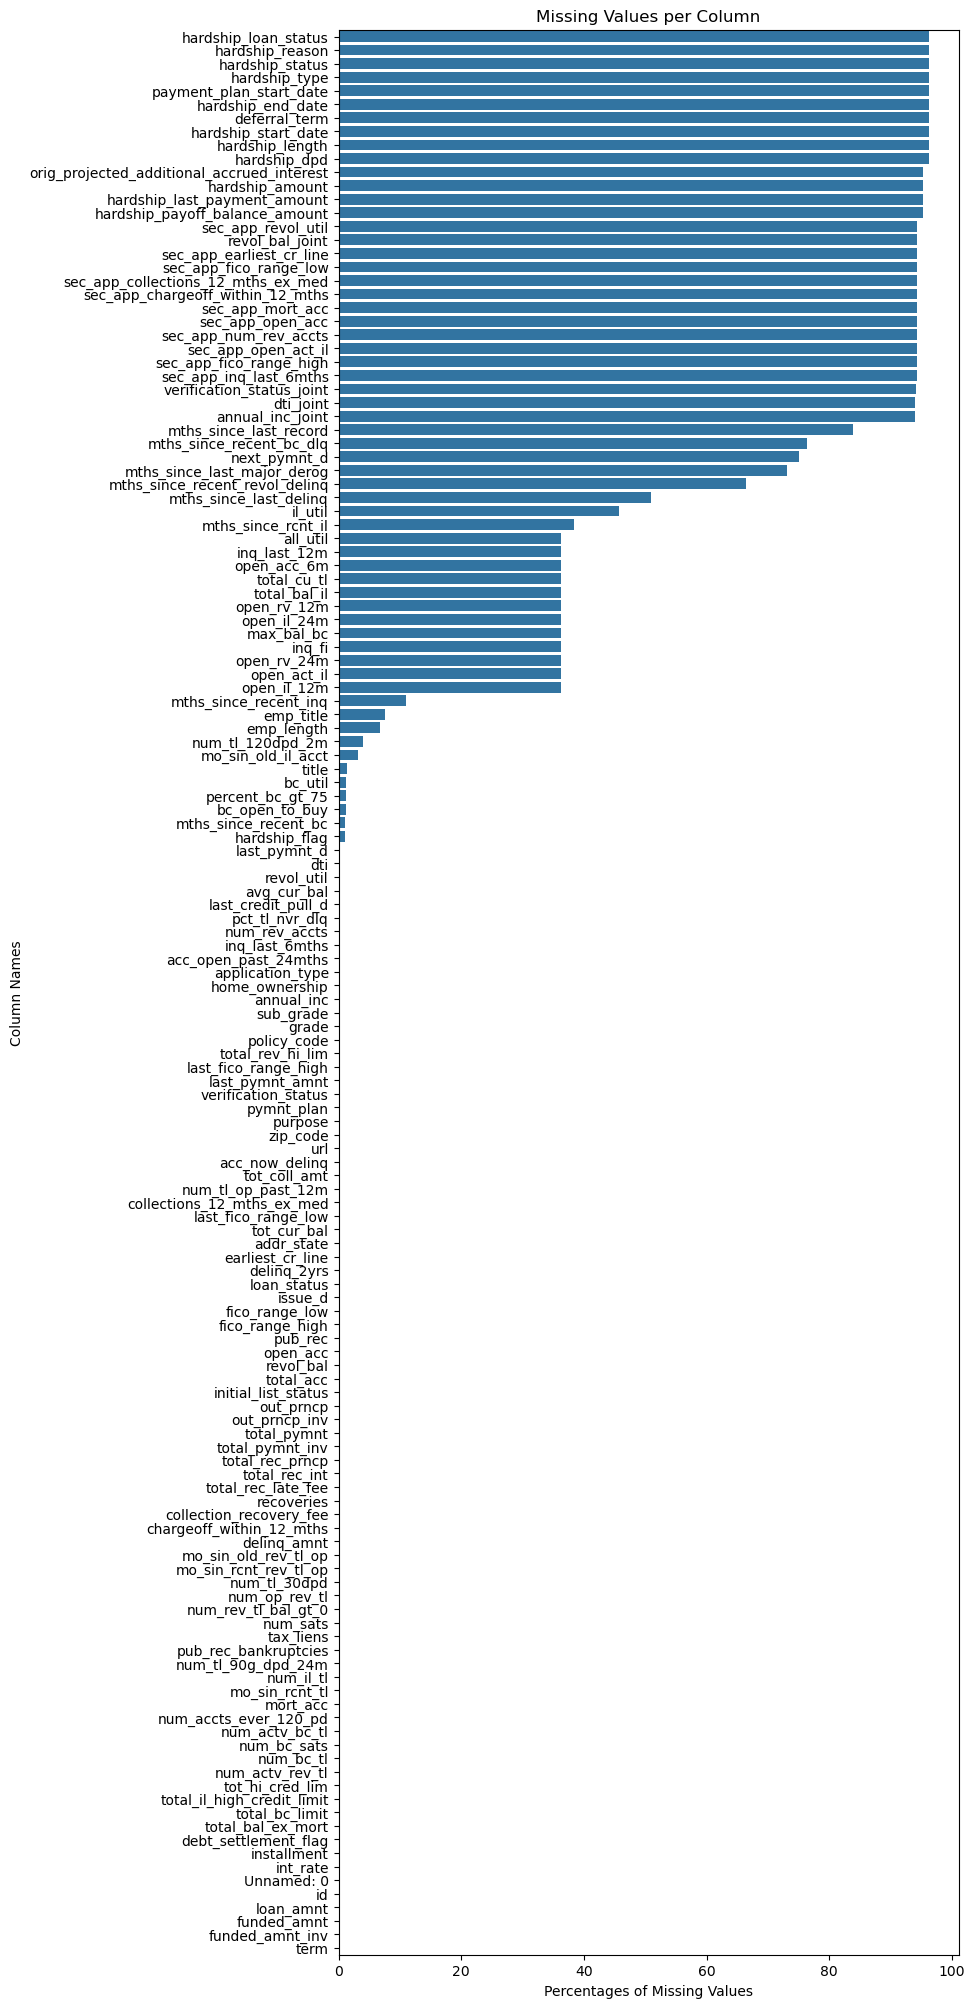

In [7]:
missing_vals = df.isna().sum() / len(df) * 100
print("Missing values [in % missing per column]:")
missing_vals = missing_vals.sort_values(ascending=False)

#print(missing_vals[missing_vals > 0].head(60))

plt.figure(figsize=(8, 25))
sns.barplot(x=missing_vals.values, y=missing_vals.index, orient='h')
plt.xlabel('Percentages of Missing Values')
plt.ylabel('Column Names')
plt.title('Missing Values per Column')
plt.show()

## Defining the target column

There is 7 different status options for the target column. To simplify we will focus on closed loans and loans that are still active.

**Closed loans:**
- **Fully Paid** --- Target Class
- Default
- Charged Off

**Active loans:**
- Current
- Late (16-30 days)
- Late (31-120 days)
- In Grace Period

The active loans are then exported to be analyzed using the pre-trained model in the business_prediction notebook.

In [8]:
display(df['loan_status'].value_counts())

df = lp.create_target_columns(df, 'loan_status')

## Separating active loans for the business predictions later on
df_active = df[df['active_loan'] == 1]

if export_mode:
    if os.path.exists('DATA/active_loans.parquet'):
        df_active.to_parquet('DATA/active_loans.parquet', index=False)

loan_status
Fully Paid            1045784
Current                423402
Charged Off            269242
Late (31-120 days)       8461
In Grace Period          4993
Late (16-30 days)        1336
Default                   212
Name: count, dtype: int64

Target columns created: active_loan, default


### Analyzing the target column

In [46]:
# Create a dataframe to display the interaction between closed/active and status
target_df = df.groupby(['active_loan', 'loan_status']).size().reset_index(name='counts')
target_df['Total %'] = round(target_df['counts'] / len(df) * 100, 2)
target_df.set_index(['active_loan', 'loan_status'], inplace=True)
display(target_df)

print("Distribution of active loans:")
active_df = target_df.loc[1].copy()
active_df['Active %'] = round(active_df['counts'] / active_df['counts'].sum() * 100, 2)
display(active_df)

print("Distribution of closed loans:")
closed_df = target_df.loc[0].copy()
closed_df['Closed %'] = round(closed_df['counts'] / closed_df['counts'].sum() * 100, 2)
display(closed_df)

# Exporting the target insights to Excel
if export_mode:
    target_df.to_excel('OUTPUT/target_insights.xlsx', sheet_name='Target Analysis', index=True)

counts  Total %
active_loan loan_status                         
0           Charged Off          269242    15.36
            Default                 212     0.01
            Fully Paid          1045784    59.64
1           Current              423402    24.15
            In Grace Period        4993     0.28
            Late (16-30 days)      1336     0.08
            Late (31-120 days)     8461     0.48

Distribution of active loans:


,counts,Total %,Active %
loan_status,,,
Current,423402,24.15,96.62
In Grace Period,4993,0.28,1.14
Late (16-30 days),1336,0.08,0.30
Late (31-120 days),8461,0.48,1.93


Distribution of closed loans:


,counts,Total %,Closed %
loan_status,,,
Charged Off,269242,15.36,20.47
Default,212,0.01,0.02
Fully Paid,1045784,59.64,79.51


#### Determining class weights

In [10]:
print(df['default'].value_counts())

pos_class_count = df['default'].value_counts().get(1, 0)  # Class 1 (loan will default)
neg_class_count = df['default'].value_counts().get(0, 0)  # Class 0 (loan will be paid)

pos_class_ratio = pos_class_count / neg_class_count

print(f"There are {pos_class_ratio:.2f} times more paid loans than defaults")

default
0    1045784
1     707647
Name: count, dtype: int64
There are 0.68 times more paid loans than defaults


### Setting X and y

In [11]:
# Featureset
X = df.drop(['default'], axis=1)
X = X[X['active_loan'] == 0]
print(f'There are currently {len(X.columns)} columns in the featureset')

# Target 
y = df[['default']][df['active_loan'] == 0]

X.shape, y.shape


There are currently 143 columns in the featureset


((1315238, 143), (1315238, 1))

### Exploring average recoveries

In [12]:
# Average percent of recoveries from overall funded amounts per loan grade

avg_recoveries_by_grade = df.groupby('grade')['recoveries'].mean() / df.groupby('grade')['funded_amnt'].mean()

# Export dictionary with the average recovery rates per grade
if export_mode:
    recovery_dict = (avg_recoveries_by_grade).to_dict()
    with open('DATA/recovery_info.json', 'w') as f:
        json.dump(recovery_dict, f)

display(avg_recoveries_by_grade)

grade
A    0.002893
B    0.007860
C    0.015271
D    0.023707
E    0.034181
F    0.045424
G    0.051605
dtype: float64

## Feature Selection: Strategic Column Removal

**Preventing Data Leakage** 

We carefully remove features that could cause data leakage - information that wouldn't be available at prediction time or that directly reveals the target variable:

1. **Hardship Columns**: These represent information about hardship plans and payment adjustments that typically occur after a loan is already in trouble. Including them would create a form of "look-ahead bias" since hardship status is often a consequence of the same financial distress that leads to default.

2. **Debt Settlement Flag**: This is a clear example of data leakage as it indicates loans already in the settlement process, which essentially means they've defaulted.

3. **Payment Dates and Recovery Information**: Columns like `next_pymnt_d`, `last_pymnt_d`, `recoveries`, and `collection_recovery_fee` contain information only available after a loan's outcome is determined or strongly correlated with loan status.

**Simplifying the Model**

4. **Joint Application Columns**: We remove these because:
   - They apply to only a subset of loans (those with co-applicants)
   - They create complications in model interpretation
   - They often contain redundant information already captured in primary applicant features
   - They may introduce missingness patterns that could bias the model

5. **Metadata and Identifiers**: Columns like `url`, `id`, and `Unnamed: 0` have no predictive value.

6. **Categorical Features with High Cardinality**: Features like `emp_title` have too many unique values to be effectively encoded without creating extremely sparse feature spaces.

7. **Location Data**: Geographic features (`zip_code`, `addr_state`) are removed to prevent potential geographic discrimination in lending decisions and to create a model that generalizes across regions.

**Handling Redundancy**

8. **Duplicate Information**: Features like `total_rec_prncp` are essentially mathematical complements of variables we're keeping (like outstanding principal). Including both doesn't add information but increases dimensionality.

This strategic feature removal focuses our model on true predictive signals available at loan application time, avoids data leakage that would artificially inflate performance metrics, and creates a more interpretable, generalizable model.

In [13]:
# Dropping all hardship columns
hardship_cols = [col for col in X.columns if 'hardship' in col] + [
    'payment_plan_start_date',
    'orig_projected_additional_accrued_interest',
    'deferral_term',
    'debt_settlement_flag' # Because it basically indicates that the loan has already defaulted
]

# Droping joint application columns

joint_app_cols = [col for col in X.columns if 'sec_app' in col] + [
    'annual_inc_joint',
    'dti_joint',
    'verification_status_joint',
    'revol_bal_joint'
]

# Defining all columns to be dropped

drop_cols = [
    'loan_status', # Target column

    # Loan information
    'url',
    'id',
    'Unnamed: 0',

    # Borrower information
    'zip_code',
    'addr_state',
    'emp_title',
    'policy_code',
    'purpose',
    'title',

    # Further assumed data leakage
    'next_pymnt_d', # since it indicates an active loan
    'last_pymnt_d', # if it's in the past it will indicate a closed loan
    'recoveries', # Data leakage
    'collection_recovery_fee', # Data leakage
    'last_pymnt_amnt', # Data leakage

    # Duplicate information
    'total_rec_prncp', # Opposite of outstanding principle, so we can discard it since they have negative correlation
    'total_rec_int', # Same as above but for interest
    'total_rec_late_fee', # Same as above but for late fees
    'total_pymnt',
    'total_pymnt_inv'
] + hardship_cols + joint_app_cols 

# Defining a column dropped set to keep track of all columns dropped and export them later to apply the same logic to the open loans
total_dropped = set()
total_dropped.update(drop_cols)
print(f"Total columns to be dropped: {len(total_dropped)}")

# Finally executing all column drops
for col in drop_cols:
    if col in X.columns:
        X.drop(col, axis=1, inplace=True)
        print(f"Column {col} dropped.")
    else:
        print(f"Column {col} not found. Might have been dropped already.")


Total columns to be dropped: 51
Column loan_status dropped.
Column url dropped.
Column id dropped.
Column Unnamed: 0 dropped.
Column zip_code dropped.
Column addr_state dropped.
Column emp_title dropped.
Column policy_code dropped.
Column purpose dropped.
Column title dropped.
Column next_pymnt_d dropped.
Column last_pymnt_d dropped.
Column recoveries dropped.
Column collection_recovery_fee dropped.
Column last_pymnt_amnt dropped.
Column total_rec_prncp dropped.
Column total_rec_int dropped.
Column total_rec_late_fee dropped.
Column total_pymnt dropped.
Column total_pymnt_inv dropped.
Column hardship_flag dropped.
Column hardship_type dropped.
Column hardship_reason dropped.
Column hardship_status dropped.
Column hardship_amount dropped.
Column hardship_start_date dropped.
Column hardship_end_date dropped.
Column hardship_length dropped.
Column hardship_dpd dropped.
Column hardship_loan_status dropped.
Column hardship_payoff_balance_amount dropped.
Column hardship_last_payment_amount d

In [14]:
len(drop_cols)

51

# 2. Data Cleaning & Feature Engineering


### Reevaluating the missing values

In [15]:
X.isna().sum().sort_values(ascending=False).head(50) / len(X)

mths_since_last_record            8.249062e-01
mths_since_recent_bc_dlq          7.533359e-01
mths_since_last_major_derog       7.202050e-01
mths_since_recent_revol_delinq    6.537798e-01
il_util                           5.466098e-01
mths_since_last_delinq            4.967656e-01
mths_since_rcnt_il                4.862230e-01
all_util                          4.703149e-01
inq_last_12m                      4.702396e-01
total_cu_tl                       4.702396e-01
open_acc_6m                       4.702396e-01
open_rv_12m                       4.702388e-01
open_act_il                       4.702388e-01
max_bal_bc                        4.702388e-01
open_il_24m                       4.702388e-01
open_il_12m                       4.702388e-01
open_rv_24m                       4.702388e-01
total_bal_il                      4.702388e-01
inq_fi                            4.702388e-01
mths_since_recent_inq             9.958730e-02
emp_length                        6.456018e-02
num_tl_120dpd

## Handling missing values

for the above missing values columns we will define replacement strategies, by classifying them into 3 categories:

- **months_since_...** columns: missing values will be replaced with a -1 since 0 would indicated a deliquency happening in the most recent month
- **utilization_rate**: missing values will be replaced with 0, since it is a ratio and 0 is a valid value


## Convert data types

There are still some data types that need to be converted to the correct type or one hot encoded

In [16]:
# Non-numeric and string columns
non_numeric_cols = X.select_dtypes(include='object').columns
print("Non-numeric columns:")
for col in non_numeric_cols:
    print(col)
    print(X[col].unique())

Non-numeric columns:
term
[' 36 months' ' 60 months']
int_rate
['  7.97%' '  9.44%' ' 16.02%' ' 13.59%' ' 23.88%' ' 17.09%' ' 28.72%'
 ' 11.99%' ' 30.84%' ' 24.85%' ' 21.45%' ' 19.03%' ' 12.62%' '  7.07%'
 ' 14.08%' ' 10.91%' ' 15.05%' ' 20.00%' '  5.32%' ' 18.06%' '  9.93%'
 '  7.35%' ' 30.65%' '  7.21%' ' 10.42%' ' 30.89%' ' 29.69%' ' 30.17%'
 ' 26.30%' ' 25.82%' ' 30.75%' ' 30.94%' ' 30.99%' ' 22.91%' ' 30.79%'
 '  6.00%' '  6.72%' '  6.08%' ' 23.87%' ' 14.07%' ' 11.98%' ' 20.39%'
 '  9.43%' ' 16.01%' ' 10.90%' ' 13.58%' '  9.92%' ' 10.41%' ' 15.04%'
 '  7.96%' ' 17.47%' '  7.34%' '  6.07%' ' 21.85%' '  5.31%' ' 18.45%'
 ' 12.61%' ' 26.77%' '  6.71%' ' 25.81%' ' 19.42%' ' 24.84%' ' 22.90%'
 '  7.46%' ' 10.07%' '  6.83%' ' 14.52%' ' 10.56%' ' 13.06%' '  8.08%'
 ' 14.03%' ' 16.46%' ' 15.49%' '  9.58%' '  6.19%' ' 11.05%' ' 12.13%'
 '  7.84%' ' 13.56%' ' 22.35%' ' 17.97%' ' 18.94%' ' 16.14%' ' 11.55%'
 '  8.46%' '  6.67%' ' 15.02%' ' 11.06%' ' 20.89%' ' 14.47%' ' 16.91%'
 ' 12.73%' '  

## Transformations

### Date Transformations

In [17]:

date_cols = ['earliest_cr_line', 'last_credit_pull_d']

X = lp.process_year_month_date(X, 'issue_d')
X = lp.process_month_date(X, date_cols)

### Adjust percentages

In [18]:
pct_cols = ['revol_util', 'int_rate']

X = lp.process_percentages(X, pct_cols)

### Adjust term columns

In [19]:
X = lp.process_term(X, 'term')

## High-correlation feature matrix

In [20]:
# Find highly correlated features (absolute correlation > 0.9)
threshold = 0.90
numerical_cols = X.select_dtypes(include='number').columns
corr_matrix = X[numerical_cols].corr()

high_corr_matrix = corr_matrix[corr_matrix.abs() > threshold]

# Create a DataFrame to store the highly correlated pairs
high_corr_features = []

# Find feature pairs with correlation above threshold
for i in range(len(corr_matrix.columns)):
    for j in range(i):  
        if abs(corr_matrix.iloc[i, j]) > threshold:
            feature1 = corr_matrix.columns[i]
            feature2 = corr_matrix.columns[j]
            corr_value = corr_matrix.iloc[i, j]
            high_corr_features.append((feature1, feature2, corr_value))

corr_df = pd.DataFrame(high_corr_features, columns=['Feature 1', 'Feature 2', 'Correlation'])
corr_df.sort_values(by='Correlation', ascending=False, inplace=True)

display(corr_df)

,Feature 1,Feature 2,Correlation
6,fico_range_high,fico_range_low,1.000000
7,out_prncp_inv,out_prncp,0.999999
0,funded_amnt,loan_amnt,0.999999
2,funded_amnt_inv,funded_amnt,0.999994
1,funded_amnt_inv,loan_amnt,0.999994
9,num_sats,open_acc,0.998833
8,num_rev_tl_bal_gt_0,num_actv_rev_tl,0.981963
10,tot_hi_cred_lim,tot_cur_bal,0.971950
12,total_il_high_credit_limit,total_bal_il,0.956302
4,installment,funded_amnt,0.950080


#### Plotting the matrices

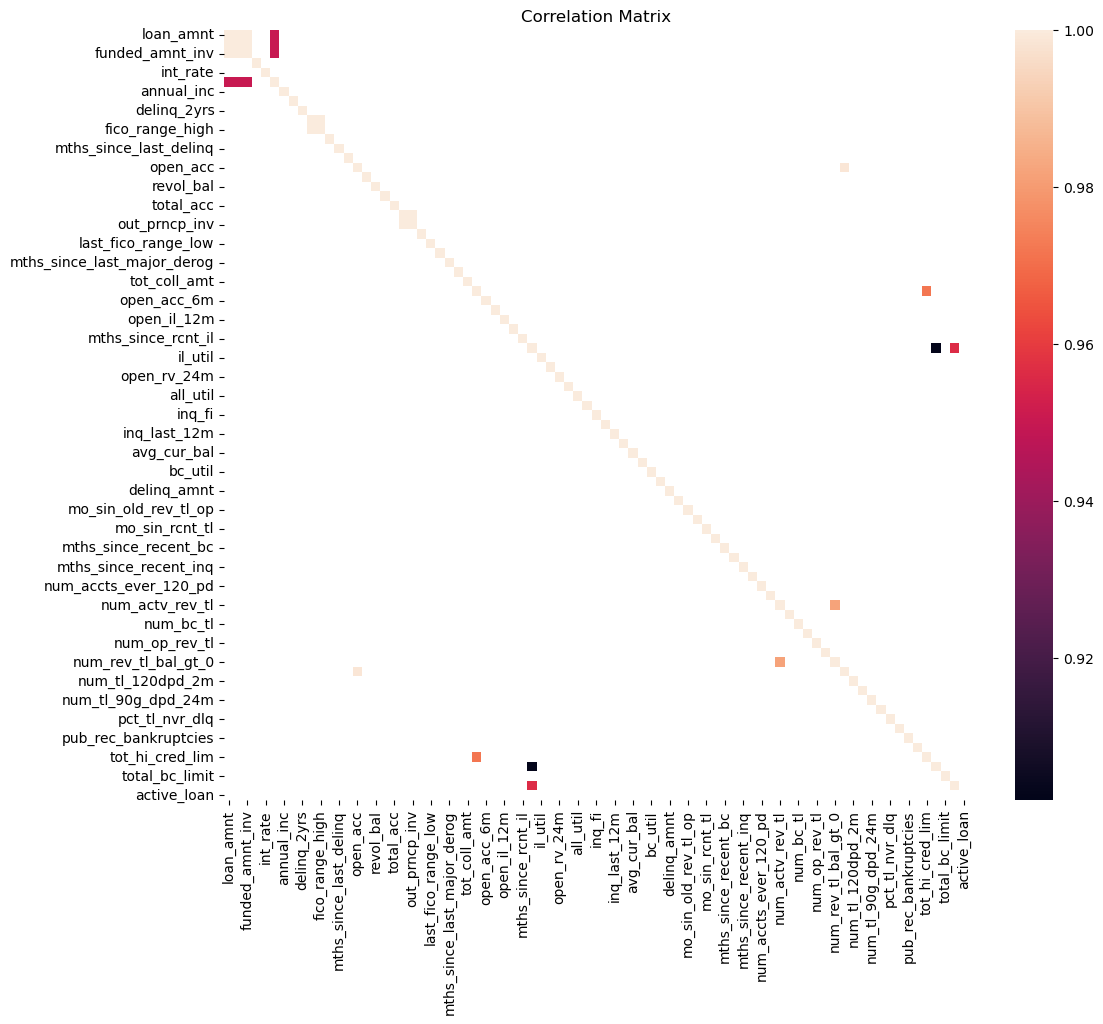

In [21]:
plt.figure(figsize=(12, 10))
sns.heatmap(high_corr_matrix, annot=False, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

c:\Users\timos\miniconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\timos\miniconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


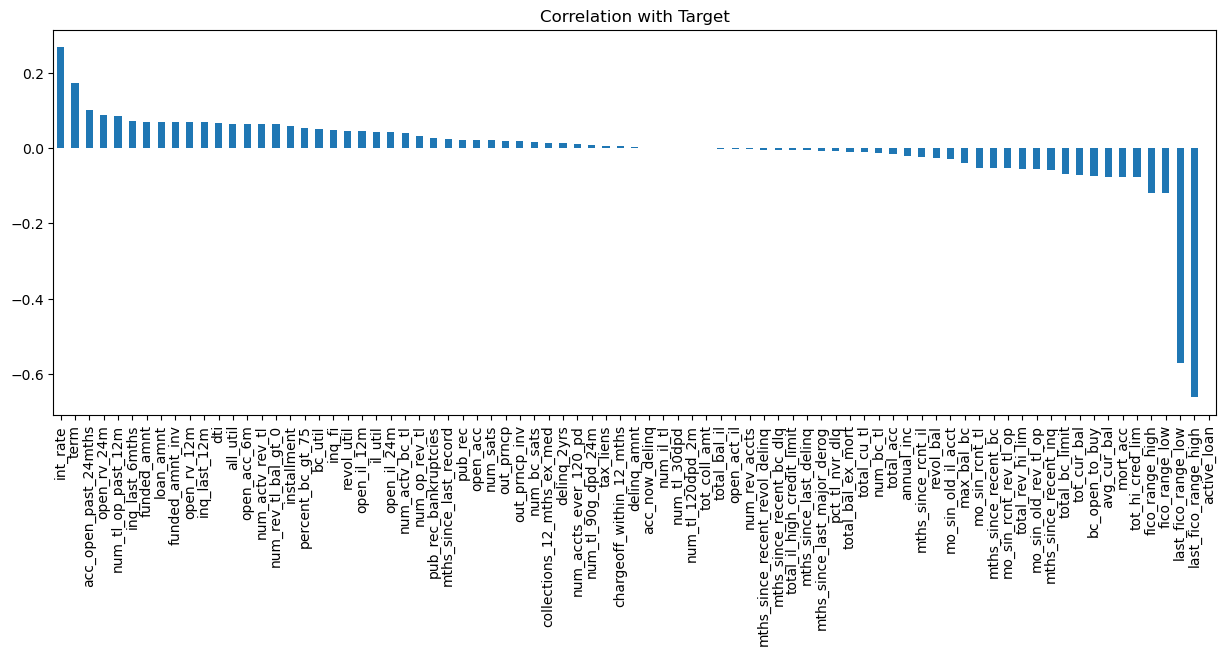

In [22]:
plt.figure(figsize=(15, 5))
target_correlations = X[numerical_cols].corrwith(y['default']).sort_values(ascending=False)
target_correlations.plot(kind='bar')
plt.title('Correlation with Target')
plt.show()

This correlation with the target is especially interesting since it gives an intuitive interpretation of both the size and direction of the relationship between each feature and the target variable. In this the, the most relevant features are:

Negative (lower means higher defaults)
- `last_fico_range_high`
- `last_fico_range_low`

Positive (higher means higher defaults)
- `term`
- `int_rate`

All of those features make intuitive sense, as they are all related to the borrower's creditworthiness and the loan's terms. The longer the term, the higher the interest rate, and the lower the FICO score, the higher the likelihood of default. 

Since both fico features are highly correlated, we will keep only one of them, but do further feature engineering to create a new feature that combines the two.

### Dropping 2.0 based on insights from correlation matrix

In [23]:
# Create a list of features to potentially drop
# Strategy: From each pair, keep the first feature (you could implement a more sophisticated approach)
high_corr_drop = []
for _, feature2, _ in high_corr_features:
    if feature2 not in high_corr_drop:
        high_corr_drop.append(feature2)

print("Features to consider dropping to reduce multicollinearity:")
for col in high_corr_drop:
    print(f"- {col}")

Features to consider dropping to reduce multicollinearity:
- loan_amnt
- funded_amnt
- funded_amnt_inv
- fico_range_low
- out_prncp
- num_actv_rev_tl
- open_acc
- tot_cur_bal
- total_bal_il


## Creating new features

Here we create 4 new features based on the fico scores:

- `avg_fico_start`: the average of the low and high starting fico scores, when the loan was issued
- `avg_fico_current`: the average of the low and high most recent fico scores
- `fico_diff`: the difference between the current and starting fico scores, to see if the borrower's creditworthiness has improved or worsened
- `fico_downgrade`: a binary feature indicating if the fico score has decreased since the loan was issued

In [24]:
X = lp.create_fico_features(X, verbose = True)

New features created: avg_fico_start, avg_fico_current, fico_diff fico_downgrade
FICO features summary:
       avg_fico_start  avg_fico_current     fico_diff  fico_downgrade
count    1.315238e+06      1.315238e+06  1.315238e+06    1.315238e+06
mean     6.987251e+02      6.680393e+02 -3.068579e+01    5.252266e-01
std      3.245462e+01      1.053654e+02  1.010591e+02    4.993634e-01
min      6.620000e+02      0.000000e+00 -8.020000e+02    0.000000e+00
25%      6.720000e+02      6.220000e+02 -7.500000e+01    0.000000e+00
50%      6.920000e+02      6.920000e+02 -5.000000e+00    1.000000e+00
75%      7.170000e+02      7.320000e+02  3.000000e+01    1.000000e+00
max      8.475000e+02      8.475000e+02  1.855000e+02    1.000000e+00


### Dropping high correlation & engineered features

In [25]:
drop_cols = high_corr_drop + date_cols + [
    'issue_d',
    'maturity_date',
    'fico_range_high',
    'fico_range_low',
    'last_fico_range_high',
    'last_fico_range_low'
] + date_cols

total_dropped.update(drop_cols)

timestamp = dt.now().strftime("%Y%m%d_%H%M%S")

with open(f'OUTPUT/Processing/dropped_columns_{timestamp}.json', 'w') as f:
    json.dump(list(total_dropped), f)

for col in drop_cols:
    if col in X.columns:
        X.drop(col, axis=1, inplace=True)
        print(f"Column {col} dropped.")
    else:
        print(f"Column {col} not found. Might have been dropped already.")

Column loan_amnt dropped.
Column funded_amnt dropped.
Column funded_amnt_inv dropped.
Column fico_range_low dropped.
Column out_prncp dropped.
Column num_actv_rev_tl dropped.
Column open_acc dropped.
Column tot_cur_bal dropped.
Column total_bal_il dropped.
Column earliest_cr_line dropped.
Column last_credit_pull_d dropped.
Column issue_d dropped.
Column maturity_date not found. Might have been dropped already.
Column fico_range_high dropped.
Column fico_range_low not found. Might have been dropped already.
Column last_fico_range_high dropped.
Column last_fico_range_low dropped.
Column earliest_cr_line not found. Might have been dropped already.
Column last_credit_pull_d not found. Might have been dropped already.


# 3. Feature Preprocessing Pipeline

### Categorical Data Processing
- **Binary Features**: Categorical columns with few levels are one-hot encoded using `binary_pipe`. The pipeline first imputes missing values with the most frequent value, then applies one-hot encoding with the ability to handle previously unseen categories during prediction.
- **Ordinal Features**: For categorical variables with meaningful order (like credit grades), we use a specialized pipeline that imputes missing values first, then applies ordinal encoding with pre-defined category hierarchies stored in the `categories` variable.

### Numerical Data Handling
- **Trailing Time Columns**: For time-related features (like months since last delinquency), we impute missing values with -1, a special marker that effectively indicates "never happened" or "not applicable."
- **Count Variables**: For count-based features, we impute missing values with 0, assuming absence of data means the count is zero.
- **Balance Columns**: For financial balances and amounts, we use median imputation to better represent the center of these often-skewed distributions.
- **General Numerical Features**: We apply standard scaling to all remaining numerical columns to normalize their range and prevent features with large scales from dominating the model.

### Design Principles
1. **Domain-Specific Knowledge**: The pipeline incorporates finance-specific assumptions, like how to interpret missing values in different contexts.
2. **Data Leakage Prevention**: Imputation strategies are carefully chosen to avoid information leakage.
3. **Robustness**: The pipeline handles missing values and unseen categories gracefully, making it suitable for production deployment.
4. **Interpretability**: By maintaining feature characteristics through appropriate transformations, the resulting model will produce more interpretable results.

This preprocessing approach ensures our models receive clean, well-structured data while preserving the meaningful patterns in the original features. The `verbose_feature_names_out=False` setting keeps the transformed column names manageable.

In [26]:
categorical_cols = [
    'application_type', 
    'initial_list_status', 
    'pymnt_plan',
    'grade',
    'sub_grade',
    'home_ownership']

# Lastly defining the categories for the ordinal columns
ordinal_cols = ['emp_length', 
                # 'home_ownership', 
                # 'grade', 
                # 'sub_grade',
                'verification_status']

emp_length_categories = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']
#home_ownership_categories = ['NONE', 'RENT', 'MORTGAGE', 'OWN', 'ANY']
#grade_categories = ['G', 'F', 'E', 'D', 'C', 'B', 'A']
#subgrade_categories = ['G5', 'G4', 'G3', 'G2', 'G1', 'F5', 'F4', 'F3', 'F2', 'F1', 'E5', 'E4', 'E3', 'E2', 'E1', 'D5', 'D4', 'D3', 'D2', 'D1', 'C5', 'C4', 'C3', 'C2', 'C1', 'B5', 'B4', 'B3', 'B2', 'B1', 'A5', 'A4', 'A3', 'A2', 'A1']
verification_status = ['Unknown','Not Verified', 'Source Verified', 'Verified']

categories = [
    emp_length_categories, 
    # home_ownership_categories, 
    # grade_categories,
    # subgrade_categories, 
    verification_status]

### ---- Columns with missing values, that need to be imputed ---- ### 

# Columns that have a trailing time, meaning they track the time since the last event; 
# If nothing happened, 0 would make it seems as if it happened last month, so we give -1

trailing_time_cols = [col for col in X.columns if '_sin' in col]

# Columns that track the balance of something, if missing, we can assume it's 0

balance_cols = [
    'tot_cur_bal', 
    'il_util', 
    'bc_util', 
    'tot_coll_amt', 
    'total_bal_il',
    'max_bal_bc',
    'all_util', 
    'total_rev_hi_lim', 
    'avg_cur_bal',
    'bc_open_to_buy', 
    'total_bal_ex_mort',
    'total_bc_limit'
]

balance_cols = [col for col in balance_cols if col not in high_corr_drop]

# Columns that track the count of something, if missing, we can assume it's 0

count_cols = [
    'open_acc_6m', 
    'open_il_12m', 
    'open_il_24m', 
    'open_rv_12m', 
    'open_rv_24m',
    'inq_fi', 
    'total_cu_tl', 
    'inq_last_12m', 
    'acc_open_past_24mths',
    'mort_acc', 
    'num_accts_ever_120_pd', 
    'num_actv_bc_tl', 
    'num_actv_rev_tl',
    'num_bc_sats', 
    'num_bc_tl', 
    'num_il_tl', 
    'num_op_rev_tl', 
    'num_rev_accts',
    'num_rev_tl_bal_gt_0', 
    'num_sats', 
    'num_tl_op_past_12m',
    'acc_now_delinq', 
    'num_tl_120dpd_2m', 
    'num_tl_30dpd', 
    'num_tl_90g_dpd_24m'
]

count_cols = [col for col in count_cols if col not in high_corr_drop]

ratio_cols = ['pct_tl_nvr_dlq', 'percent_bc_gt_75', 'il_util', 'bc_util', 'all_util', 'total_rev_hi_lim']
ratio_cols = [col for col in ratio_cols if col not in high_corr_drop]

transformed_cols = date_cols + pct_cols + categorical_cols + ordinal_cols + trailing_time_cols + balance_cols + count_cols + ratio_cols
numerical_cols = [col for col in X.columns if col not in transformed_cols and isinstance(X[col].iloc[0], (int, float))]

# Check for duplicate and missing columns

missing_cols = [col for col in X.columns if col not in transformed_cols + numerical_cols]

if missing_cols:
    print("Missing columns:")
    for col in missing_cols:
        print(col)
else:
    print("All columns accounted for the preprocessing steps")

Missing columns:
term
active_loan
fico_downgrade


## Fitting the preprocessing pipeline

In this step we will set up the preprocessing pipeline and apply it to the dataset. This basically combines all the steps we have done so far into one pipeline which can then be exported and applied to the open loans dataset.

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# Create preprocessing for ordinal columns that includes imputation first
# We'll use a separate pipeline for ordinal columns to handle missing values first
ordinal_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(categories=categories, handle_unknown="use_encoded_value", unknown_value=-1))
])

# Create preprocessing for binary columns with missing value handling
binary_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

pre_steps = [
    ('binary_transformer', binary_pipe, categorical_cols),
    ('ordinal_transformer', ordinal_pipe, ordinal_cols),
    ('imputer_trailing', SimpleImputer(strategy='constant', fill_value=-1), trailing_time_cols),
    ('imputer_zero', SimpleImputer(strategy='constant', fill_value=0), count_cols),
    ('imputer_balance', SimpleImputer(strategy='median'), balance_cols),
    ('scaler', StandardScaler(), numerical_cols)
]

pre_pipe = ColumnTransformer(pre_steps, remainder='passthrough', verbose_feature_names_out = False)

### Fitting & Exporting the preprocessor

In [28]:
X_transformed = pre_pipe.fit_transform(X.drop('active_loan', axis=1))

if export_mode:
    joblib.dump(pre_pipe, f'OUTPUT/Processing/preprocessing_pipeline_{timestamp}.pkl')

### Creating first baseline model to assess feature importance

In this step we create a light baseline model to assess initial feature importance. This helps to understand which features are most important or which can be dropped / engineered further before spending a lot of time training the models in the gridsearch.

In [29]:
if sampled_mode and sample_frac < 0.05: # Skip in full training mode
    from sklearn.ensemble import RandomForestClassifier

    rfc = RandomForestClassifier(n_estimators=100, random_state = rs)
    rfc.fit(X_transformed, y)

    # Extract feature importances

    feature_importances = rfc.feature_importances_
    feature_names = pre_pipe.get_feature_names_out()

    feature_importances_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

    print(f'Total features: {len(feature_importances_df)}')
    print("Top 50 features:")

    plt.figure(figsize=(15, 10))
    sns.barplot(x='importance', y='feature', data=feature_importances_df.head(50))
    plt.title('Feature Importances')
    plt.show()

# 4. GridSearch

Since our dataset also contains loans that are still active, we will split the dataset into training and test set based on the target column. This way we can ensure that the model is not trained on loans that are still active.

### Data Preparation and Splitting
The dataset is split into training (80%) and testing (20%) sets using stratified sampling to maintain class distribution across splits, which is crucial for our imbalanced classification problem.

### Model Ensemble with Advanced Algorithms
Here we combine two well-known gradient boosting algorithms:
1. **XGBoost**: Configured with moderate tree depth and learning rate
2. **LightGBM**: Generally faster than XGBoost with a leaf-wise growth strategy

Both models are initialized with class balancing via `scale_pos_weight` to address the imbalance in our target variable.

### Addressing Class Imbalance with SMOTE
Since default loans (positive class) are underrepresented, we apply SMOTE oversampling to generate synthetic examples of the minority class, creating a more balanced training set.

### Robust Pipeline Construction
We build an imbalanced-learn pipeline that:
1. First imputes any missing values
2. Applies SMOTE oversampling
3. Trains an ensemble of XGBoost and LightGBM models
4. Uses soft voting (probability averaging) for final predictions

### Hyperparameter Optimization
Using RandomizedSearchCV, we efficiently search the parameter space with:
- 10 random combinations from possible parameters (to save time and resources)
- 3-fold cross-validation for reliable performance estimation
- Custom scoring metric (`loan_scorer`) optimized for our business objective with a higher penalty for false negatives (70% on recall, 30% on the weighted average of precision and recall)
- Testing different imputation strategies and model-specific parameters
- Focus on class weighting and ensemble size as key tuning parameters

In [30]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Custom scorer that combines f1 and recall with more weight on recall
def weighted_score(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    # 70% weight on recall, 30% on F1
    return 0.3 * f1 + 0.7 * recall

loan_scorer = make_scorer(weighted_score)

In [48]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
import numpy as np
import os
import multiprocessing

# Set number of threads for efficient parallel processing

n_cores = multiprocessing.cpu_count()
n_jobs = max(1, n_cores - 2) 

print(f"System has {n_cores} cores, using {n_jobs} for parallel processing")

# Control thread usage in underlying libraries
os.environ["OMP_NUM_THREADS"] = "2" 
os.environ["OPENBLAS_NUM_THREADS"] = "2"
os.environ["MKL_NUM_THREADS"] = "2" 

start_time = time.time()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_transformed, np.ravel(y), test_size=0.2, random_state=rs, stratify=y)

print(f"Training set shape: {X_train.shape}")

# Define the models with some initial hyperparameters (based on previous tuning)
xgb_model = XGBClassifier(
    random_state=rs,
    max_depth=5,
    n_estimators=250,
    learning_rate=0.05,
    scale_pos_weight=pos_class_ratio,
    subsample=0.8,          
    colsample_bytree=0.8,
    n_jobs=1  
)

lgb_model = lgb.LGBMClassifier(
    random_state=rs,
    verbose=-1,
    num_leaves=31,
    max_depth=3,
    n_estimators=250,
    learning_rate=0.05,
    scale_pos_weight=pos_class_ratio,
    subsample=0.8,            
    colsample_bytree=0.8,
    n_jobs=1 
)

# Use SMOTE for oversampling
smote = SMOTE(sampling_strategy='minority', random_state=rs, k_neighbors=5)

smote_pipe = ImbPipeline([
    ('imputer', SimpleImputer(strategy='mean')), 
    ('smote', smote),
    ('ensemble', VotingClassifier(
        estimators=[
            ('xgb', xgb_model),
            ('lgb', lgb_model)
        ],
        voting='soft',
        n_jobs=1  
    ))
])

param_distributions = {

    # Initial imputer strategy

    'imputer__strategy': ['mean', 'median'],

    # XGBoost parameters
    'ensemble__xgb__scale_pos_weight': [pos_class_ratio, pos_class_ratio * 1.5],
    'ensemble__xgb__n_estimators': [100, 200],

    # LightGBM parameters
    'ensemble__lgb__scale_pos_weight': [pos_class_ratio, pos_class_ratio * 1.5],
    'ensemble__lgb__n_estimators': [100, 200]
}

n_iter = 10 
cv_folds = 3 


random_search = RandomizedSearchCV(
    smote_pipe,
    param_distributions=param_distributions,
    n_iter=n_iter,
    cv=cv_folds,
    scoring=loan_scorer,
    n_jobs=n_jobs,  
    verbose=2,
    random_state=rs,
    error_score='raise',
    pre_dispatch='2*n_jobs' 
)

# Fit the model - to active uncomment

#random_search.fit(X_train, y_train)
#print(f"Best weighted score: {random_search.best_score_:.4f}")

end_time = time.time()
print(f"Total time taken: {(end_time - start_time) / 60:.2f} minutes")

System has 8 cores, using 6 for parallel processing
Training set shape: (1052190, 126)
Total time taken: 0.17 minutes


In [ ]:
# Re-import the model if needed
#best_model = random_search.best_estimator_

best_model = joblib.load('OUTPUT/Models/best_xgboost_full_20250317_213829.pkl')

### Storing the best model and its metrics

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

os.makedirs('OUTPUT', exist_ok=True)

if sampled_mode:
    model_filename = f'OUTPUT/Models/best_xgboost_small_{timestamp}.pkl'
    metrics_filename = f'OUTPUT/Metrics/model_metrics_small_{timestamp}.xlsx'
elif len(df) == len(df_full):
    model_filename = f'OUTPUT/Models/best_xgboost_full_{timestamp}.pkl'
    metrics_filename = f'OUTPUT/Metrics/model_metrics_full_{timestamp}.xlsx'
else:
    print("No model saved. Please specify if the model was trained on the full dataset or a sample.")
    model_filename = None

if export_mode:
    joblib.dump(best_model, model_filename)
    print(f"Model saved to {model_filename}")

# Create metrics dataframe

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)
pct_matrix = conf_matrix / len(y_test) * 100

metrics_df = pd.DataFrame({
    'Metric': ['Scoring Metric', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'Best Parameters', 'Dataset Size', 'Sample Fraction', 'Start Time', 'End Time', 'Training Time [minutes]'],
    'Value': [
        str(loan_scorer),
        accuracy_score(y_test, y_pred), 
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred), 
        f1_score(y_test, y_pred),
        roc_auc,
        str(best_model.named_steps['ensemble'].estimators_),
        len(df),
        sample_frac if sampled_mode else 1.0,
        dt.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S'),
        dt.fromtimestamp(end_time).strftime('%Y-%m-%d %H:%M:%S'),
        (end_time - start_time)/60
        ]
})

if export_mode:
    # Save metrics to Excel
    with pd.ExcelWriter(metrics_filename) as writer:
        metrics_df.to_excel(writer, sheet_name='Summary', index=False)
        pd.DataFrame(report).transpose().to_excel(writer, sheet_name='Classification Report')
        pd.DataFrame(conf_matrix).to_excel(writer, sheet_name='Confusion Matrix')
        
    print(f"Model metrics saved to {metrics_filename}")

# 5. Evaluating & Interpreting the best model

### Confusion Matrix

,Metric,Value
0,Scoring Metric,"make_scorer(weighted_score, response_method='p..."
1,Accuracy,0.901858
2,Precision,0.759651
3,Recall,0.762075
4,F1,0.760861
5,ROC AUC,0.948081
6,Best Parameters,"[XGBClassifier(base_score=None, booster=None, ..."
7,Dataset Size,1753431
8,Sample Fraction,1.0
9,Start Time,2025-03-19 21:44:36


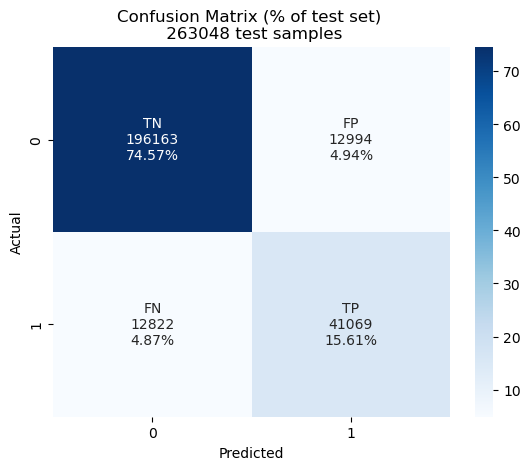

In [40]:
display(metrics_df)

# Plot confusion matrix
group_names = ['TN', 'FP', 'FN', 'TP']
group_counts = [f"{value:0.0f}" for value in conf_matrix.flatten()]
group_percentages = [f"{value:.2f}%" for value in pct_matrix.flatten()]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(pct_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (% of test set) \n {len(y_test)} test samples')
plt.show()

### Interpreting the Confusion Matrix & Classification report

The metrics table above provides a comprehensive view of the model capabilities, however limited they might be at the moment.

### Business Implications

- **True Negatives (TN)**: The model correctly identified 196,163 loans as non-defaulted, making up 74.57% of the total test set. 
- **False Positives (FP)**: 12,994 loans (4.94%) were incorrectly classified as defaulted when they were actually safe. This would mean a lost investment opportunity for us as investors buying into these loans as we would have missed out on the returns.
- **False Negatives (FN)** 12,822 loans (4.87%) were misclassified as safe but ended up defaulting. This is particularly risky, as it leads to losing the full amount payed to buy the loan from the original lender. This suggest that nearly 1 in 20 defaulting loans were misclassified as safe. In our case, this could lead (and will lead as we shall see).
- **True Positives (TP)**: 41,069 loans (15.61%) were correctly identified as defaults, allowing the lender to take preventive measures (e.g., rejecting applications or adjusting terms).

### Potential Adjustments
Depending on the business objective, we are able to adjust the decision threshold to be more or less strict. If minimizing financial risk is the priority, I might want to reduce false negatives, even if it slightly increases false positives. On the other hand, if maximizing loan approvals is the goal, I could consider reducing false positives while keeping an eye on default risks.

This is something to have a closer look at in the business_prediction notebook.

### Plotting the ROC-AUC curve of the best model

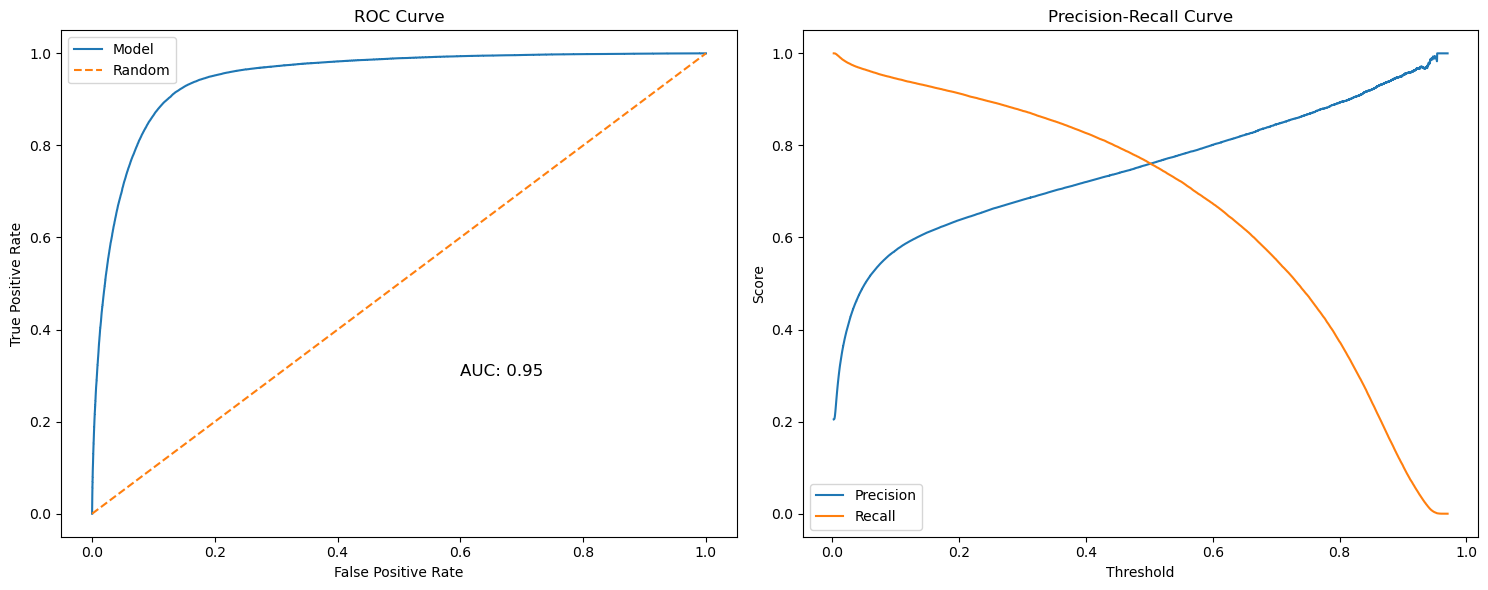

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve

# Get model probabilities
y_proba = best_model.predict_proba(X_test)[:, 1]

# Precision-recall curve to adjust threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)

# Create figure with two subplots
fig, (roc_ax, pr_ax) = plt.subplots(1, 2, figsize=(15, 6))

# Plot ROC curve
roc_ax.plot(fpr, tpr)
roc_ax.plot([0, 1], [0, 1], '--')
roc_ax.set_xlabel('False Positive Rate')
roc_ax.set_ylabel('True Positive Rate')
roc_ax.legend(['Model', 'Random'])
roc_ax.text(0.6, 0.3, f'AUC: {roc_auc:.2f}', fontsize=12)
roc_ax.set_title('ROC Curve')

# Plot Precision-Recall curve
pr_ax.plot(thresholds, precision[:-1], label="Precision")
pr_ax.plot(thresholds, recall[:-1], label="Recall")
pr_ax.set_xlabel("Threshold")
pr_ax.set_ylabel("Score")
pr_ax.legend()
pr_ax.set_title('Precision-Recall Curve')

plt.tight_layout()
plt.show()


The ROC curve (left) shows the trade-off between the True Positive Rate (TPR) and False Positive Rate (FPR) across different classification thresholds. The model's curve rises sharply and stays close to the top-left, indicating strong performance. The diagonal dashed line represents random guessing, and since the model significantly outperforms it, the classification power is solid.

The Precision-Recall curve (right) highlights the balance between precision (correct default predictions) and recall (capturing all actual defaults) as the decision threshold changes. This is especially important given the class imbalance often present in loan default prediction.

Final Thoughts & Next Steps
The evaluation confirms that the model effectively differentiates between risky and non-risky loans. However, the trade-off between precision and recall should be considered based on business priorities—whether minimizing false negatives (missed defaults) or false positives (incorrect rejections) is more critical.

With the model validated, the next step is applying it to open loans, helping identify high-risk borrowers and optimizing lending decisions to balance profitability and risk exposure. This will be covered in the business_prediction notebook.